# Grover's Algorithm

In [1]:
import numpy as np
from qiskit import IBMQ, QuantumCircuit, Aer, execute
from qiskit.quantum_info import Operator
from qiskit.providers.ibmq import least_busy
from qiskit.visualization import plot_histogram
from qiskit.tools.jupyter import *

provider = IBMQ.load_account()

In [2]:
def phase_oracle(n, indices_to_mark, name="Oracle"):
    qc = QuantumCircuit(n, name=name)
    oracle_matrix = np.identity(2**n)
    for index_to_mark in indices_to_mark:
        oracle_matrix[index_to_mark, index_to_mark] = -1
    qc.unitary(Operator(oracle_matrix), range(n))
    return qc

def diffuser(n):
    qc = QuantumCircuit(n, name='Diff - "V"')
    qc.h(range(n))
    qc.append(phase_oracle(n, [0]), range(n))
    qc.h(range(n))
    return qc

def grover(n, marked):
    qc = QuantumCircuit(n, n)
    # determine number of rounds
    r = int(np.round(np.pi/(4*np.arcsin(np.sqrt(len(marked)/2**n))) - 1/2))
    print(f'{n} qubits, basis state {marked} marked, {r} rounds')
    qc.h(range(n))
    for _ in range(r):
        qc.append(phase_oracle(n, marked), range(n))
        qc.append(diffuser(n), range(n))
    qc.measure(range(n), range(n))
    return qc

In [3]:
n = 5
x = np.random.randint(2**n)
marked = [x]
qc = grover(n, marked)

qc.draw()

5 qubits, basis state [24] marked, 4 rounds


┌───┐┌─────────┐┌─────────────┐┌─────────┐┌─────────────┐┌─────────┐»
q_0: ┤ H ├┤0        ├┤0            ├┤0        ├┤0            ├┤0        ├»
     ├───┤│         ││             ││         ││             ││         │»
q_1: ┤ H ├┤1        ├┤1            ├┤1        ├┤1            ├┤1        ├»
     ├───┤│         ││             ││         ││             ││         │»
q_2: ┤ H ├┤2 Oracle ├┤2 Diff - "V" ├┤2 Oracle ├┤2 Diff - "V" ├┤2 Oracle ├»
     ├───┤│         ││             ││         ││             ││         │»
q_3: ┤ H ├┤3        ├┤3            ├┤3        ├┤3            ├┤3        ├»
     ├───┤│         ││             ││         ││             ││         │»
q_4: ┤ H ├┤4        ├┤4            ├┤4        ├┤4            ├┤4        ├»
     └───┘└─────────┘└─────────────┘└─────────┘└─────────────┘└─────────┘»
c: 5/════════════════════════════════════════════════════════════════════»
                                                                         »
«     ┌─────────────┐┌─────────┐┌─────────────┐┌─┐            
«q_0: ┤0            ├┤0        ├┤0            ├┤M├────────────
«     │             ││         ││             │└╥┘┌─┐         
«q_1: ┤1            ├┤1        ├┤1            ├─╫─┤M├─────────
«     │             ││         ││             │ ║ └╥┘┌─┐      
«q_2: ┤2 Diff - "V" ├┤2 Oracle ├┤2 Diff - "V" ├─╫──╫─┤M├──────
«     │             ││         ││             │ ║  ║ └╥┘┌─┐   
«q_3: ┤3            ├┤3        ├┤3            ├─╫──╫──╫─┤M├───
«     │             ││         ││             │ ║  ║  ║ └╥┘┌─┐
«q_4: ┤4            ├┤4        ├┤4            ├─╫──╫──╫──╫─┤M├
«     └─────────────┘└─────────┘└─────────────┘ ║  ║  ║  ║ └╥┘
«c: 5/══════════════════════════════════════════╩══╩══╩══╩══╩═
«                                               0  1  2  3  4

## Run on simulator



{'00010': 1, '10101': 1, '10001': 1, '01101': 2, '11100': 1, '01111': 3, '10000': 1, '01100': 1, '01000': 1, '11000': 9988}


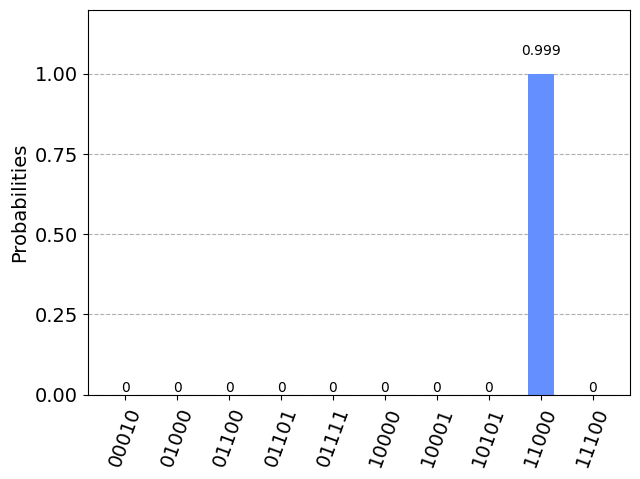

In [4]:
backend = Aer.get_backend('qasm_simulator')
result = execute(qc, backend, shots=10000).result()
counts = result.get_counts(qc)
print(counts)
plot_histogram(counts)

## What happes if we run just once (and not 4 times)?

5 qubits, basis state [17] marked, 4 rounds


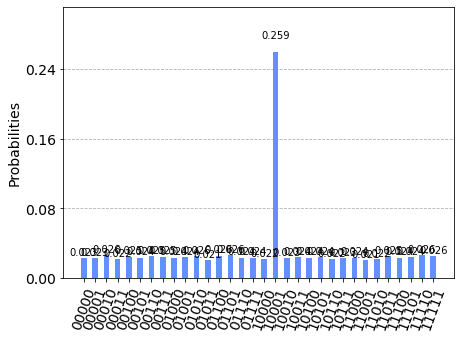

In [15]:
def grover_run_roundwise(n, marked):
    r = int(np.round(np.pi/(4*np.arcsin(np.sqrt(len(marked)/2**n)))-1/2))
    print(f'{n} qubits, basis state {marked} marked, {r} rounds')
    counts = []
    for i in range(r):
        qc = QuantumCircuit(n, n)
        qc.h(range(n))
        for _ in range(i+1):
            qc.append(phase_oracle(n, marked), range(n))
            qc.append(diffuser(n), range(n))
        qc.measure(range(n), range(n))
        result = execute(qc, backend, shots=10000).result()
        counts.append(result.get_counts(qc))
    return counts

backend = Aer.get_backend('qasm_simulator')
counts = grover_run_roundwise(n, marked)
plot_histogram(counts[0])

In [16]:
print(counts[3])

{'11011': 2, '01110': 1, '10001': 9990, '00101': 2, '11110': 1, '00010': 1, '10110': 1, '11010': 1, '00011': 1}


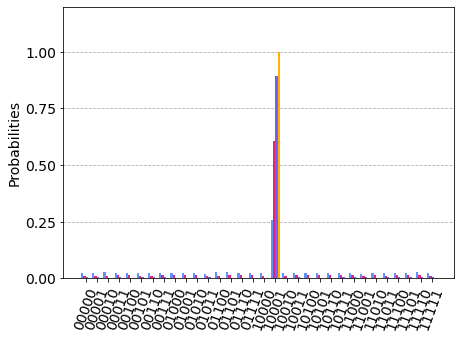

In [17]:
plot_histogram(counts, bar_labels=False)

## Running on a device
in this case, 2 marked elements

In [20]:
n = 3
x = np.random.randint(2**n)
y = np.random.randint(2**n)
while y == x:
    y = np.random.randint(2**n)
marked = [x, y]
qc = grover(n, marked)

# provider = IBMQ.get_provider(hub='ibm-q-internal', group='deployed', project='default')
# backend = provider.get_backend('ibm_hanoi')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= n \
                                                        and not x.configuration().simulator \
                                                        and x.status().operational == True))
print(f'backend: {backend}')
%qiskit_job_watcher

shots = 20000
job = execute(qc, backend=backend, shots=shots, optimization_level=3)
print(job.job_id())

3 qubits, basis state [3, 6] marked, 1 rounds
backend: ibmq_belem


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

6336c194d808539e5c6a2d8c


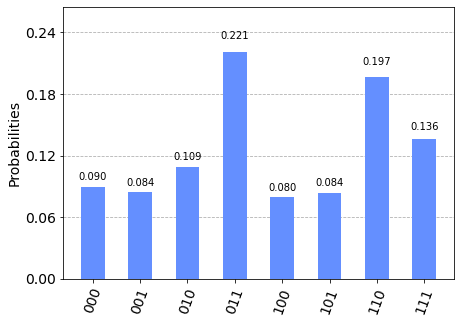

In [21]:
# get results
results = job.result()
answer = results.get_counts()
plot_histogram(answer)

a lot of noise, but still good enough to see the results

The oracle here knows the marked element - not useful to create an oracle that knows the answer.

More realistic and useful applications are satisfiability problems, where some constraints are given. The oracle just checks whether these constraints are satisfied or not -> next video (satisfiability problem)